# MP3: Logistic Regression

The purpose of this first task is to get familiar with Sentiment Classification by essentially creating our own “Sentiment Analyzer”.

The dataset given is essentially, a large number of Movie Reviews that contains separate labeled train and test sets. The task here is to train a Logistic Regression classifier on the train set and report the model's accuracy on the test set.

### Importing Libraries

In [1]:
import os
import re
import string
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

### Dataset info:

The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k `pos` and 25k `neg`).

There are two top-level directories `[train/, test/]` corresponding to the training and test sets. Each contains `[pos/, neg/]` directories for the reviews with binary labels positive and negative. Within these directories, reviews are stored in text files named following the convention `<id>_<rating>.txt` where `id` is a unique id and `rating` is the star rating for that review on a 1-10 scale.

Loading the dataset in the cell below.

In [2]:
def load_reviews(directory):
    reviews = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r', encoding = 'utf-8') as f:
            review = f.read()
            reviews.append((review))
    return reviews

train_directory = 'train'
test_directory = 'test'

train_positive_reviews = load_reviews(os.path.join(train_directory, 'pos'))
train_negative_reviews = load_reviews(os.path.join(train_directory, 'neg'))
test_positive_reviews = load_reviews(os.path.join(test_directory, 'pos'))
test_negative_reviews = load_reviews(os.path.join(test_directory, 'neg'))

### Preprocessing the data

In this preprocessing stage we would need to make certain changes to the dataset before we can work with it.

We will be removing some stop words, punctuation marks, special characters and converting the text to lower case. The `string` and `regex` modules prove to be useful for this purpose. The stop words list used for this task is provided in the repository under the text file, namely `stop_words.txt`.

In [3]:
def preProcessing(text, stop_words):
    text = text.lower() # converting to lower case
    text = re.sub(f"[{string.punctuation}]", ' ', text) # removing special characters and punctuation
    text = re.sub(r'\s+', ' ', text) # removing extra spaces
    words = text.split()
    words = [word for word in words if word not in stop_words] # removing the stop words
    processed_text = ' '.join(words)

    return processed_text

# reading the stop words from the 'stop_words.txt' file
with open('stop_words.txt', 'r', encoding = 'utf-8') as file:
    stop_words = set(file.read().splitlines())

# preprocessing the train data and overwriting it
train_positive_reviews = [preProcessing(review, stop_words) for review in train_positive_reviews]
train_negative_reviews = [preProcessing(review, stop_words) for review in train_negative_reviews]

# preprocessing the test data and overwriting it
test_positive_reviews = [preProcessing(review, stop_words) for review in test_positive_reviews]
test_negative_reviews = [preProcessing(review, stop_words) for review in test_negative_reviews]

print("Last five positive and negative reviews from the training data:")
print(" ")
for i, review in enumerate(train_positive_reviews[-5:], start = 1):
    print(f"Positive Review {i}: {review}")
print(" ")
for i, review in enumerate(train_negative_reviews[-5:], start = 1):
    print(f"Negative Review {i}: {review}")

Last five positive and negative reviews from the training data:
 
Positive Review 1: seeing vote average pretty low fact clerk video store thought ok much expectations renting film br br contrary enjoyed lot charming movie need grow enjoyed beginning mel brooks gives great performance lead character think somewhat different usual persona movies br br lot knockout jokes something like rather hilarious scenes overall enjoyable easy watch film br br recommended
Positive Review 2: plot wretched unbelievable twists however chemistry mel brooks leslie ann warren excellent insight comes moments provides philosophical handle anyone could pick embrace life br br one several moments wonderfully memorable
Positive Review 3: amazed movie others average 5 stars lower crappy movies averaging 7 10 stars imdb fanboy mentality strikes movie came everyone slammed even ex girlfriend said movie questionable years later sat watch movie found enjoying even laughing quite bit replacement killers movies peopl

### Feature Extraction

In this feature extraction step we will represent each review by the two features $x^{(1)}$: count of positive words, and $x^{(2)}$: count of negative words, and a class label $y$ as shown in the table below:

| Feature | Definition | Comment |
| --- | --- | --- |
| $x^{(1)}$ | count(positive words) ∈ review | Positive lexicon is provided |
| $x^{(2)}$ | count(negative words) ∈ review | Negative lexicon is provided |
| $y$ | 1 if positive, 0 otherwise | Mentioned in directory name |

Extracting features and printing five positive class datapoints and five negative class datapoints from training dataset, each showing the three aforementioned values.

In [4]:
positive_words = set(open('positive_words.txt', 'r').read().splitlines())
negative_words = set(open('negative_words.txt', 'r').read().splitlines())

def PosNeg_words(review, positive_words, negative_words):
    words = review.split()
    positive_word_count = sum(1 for word in words if word in positive_words)
    negative_word_count = sum(1 for word in words if word in negative_words)
    return positive_word_count, negative_word_count

positive_train_fe = []
for review in train_positive_reviews:
    positive_word_count, negative_word_count = PosNeg_words(review, positive_words, negative_words)
    label = 1
    positive_train_fe.append((positive_word_count, negative_word_count, label))

negative_train_fe = []
for review in train_negative_reviews:
    positive_word_count, negative_word_count = PosNeg_words(review, positive_words, negative_words)
    label = 0
    negative_train_fe.append((positive_word_count, negative_word_count, label))
    
training_data = positive_train_fe + negative_train_fe # this holds the entirety of the training data with features extracted

print("Five positive class datapoints:")
for i in range(5):
    print(f"Positive Word Count: {positive_train_fe[i][0]}, Negative Word Count: {positive_train_fe[i][1]}, Class Label: {positive_train_fe[i][2]}")
print(" ")
print("Five negative class datapoints:")
for i in range(5):
    print(f"Positive Word Count: {negative_train_fe[i][0]}, Negative Word Count: {negative_train_fe[i][1]}, Class Label: {negative_train_fe[i][2]}")

positive_test_fe = []
for review in test_positive_reviews:
    positive_word_count, negative_word_count = PosNeg_words(review, positive_words, negative_words)
    label = 1
    positive_test_fe.append((positive_word_count, negative_word_count, label))

negative_test_fe = []
for review in test_negative_reviews:
    positive_word_count, negative_word_count = PosNeg_words(review, positive_words, negative_words)
    label = 0
    negative_test_fe.append((positive_word_count, negative_word_count, label))

testing_data = positive_test_fe + negative_test_fe # this holds the entirety of the test data made into a list with features extracted

# shuffling both the training and testing data because I think that might positively impact the models performance later on
random.shuffle(testing_data)
random.shuffle(training_data)

Five positive class datapoints:
Positive Word Count: 5, Negative Word Count: 5, Class Label: 1
Positive Word Count: 17, Negative Word Count: 15, Class Label: 1
Positive Word Count: 9, Negative Word Count: 7, Class Label: 1
Positive Word Count: 8, Negative Word Count: 6, Class Label: 1
Positive Word Count: 6, Negative Word Count: 2, Class Label: 1
 
Five negative class datapoints:
Positive Word Count: 5, Negative Word Count: 8, Class Label: 0
Positive Word Count: 33, Negative Word Count: 50, Class Label: 0
Positive Word Count: 8, Negative Word Count: 4, Class Label: 0
Positive Word Count: 6, Negative Word Count: 10, Class Label: 0
Positive Word Count: 10, Negative Word Count: 25, Class Label: 0


### Preparing the data (features extracted) for evaluation:

Splitting the training dataset into a `9:1` split for training and evaluation. This evaluation dataset will later be used to finetune the hyperparameters.

In [5]:
splitting_ratio = 0.9

split_index = int(len(training_data) * splitting_ratio)

training_dataset = training_data[:split_index]
evaluation_dataset = training_data[split_index:]

print("Size of Training Dataset:", len(training_dataset))
print("Size of Evaluation Dataset:", len(evaluation_dataset))

# after shuffling, I am seperating both the training and testing data into x_train & y_train and x_test & y_test
x_train = [[feature[0], feature[1]] for feature in training_dataset]
y_train = [label[2] for label in training_dataset]

x_test = [[feature[0], feature[1]] for feature in testing_data]
y_test = [label[2] for label in testing_data]

# doing the same for the validation/evaluation dataset
x_validate = [[feature[0], feature[1]] for feature in evaluation_dataset]
y_validate = [label[2] for label in evaluation_dataset]

# converting the lists to numpy arrays for convenience
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

x_validate = np.array(x_validate)
y_validate = np.array(y_validate)

# checking the shapes of the new variables
print(" ")
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print(" ")
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(" ")
print("x_validate shape:", x_validate.shape)
print("y_validate shape:", y_validate.shape)

Size of Training Dataset: 22500
Size of Evaluation Dataset: 2500
 
x_train shape: (22500, 2)
y_train shape: (22500,)
 
x_test shape: (25000, 2)
y_test shape: (25000,)
 
x_validate shape: (2500, 2)
y_validate shape: (2500,)


### Implementation of Logistic Regression

Creating a class, and implementing the functionality of a fully fledged Logistic Regression model. A description of the methods in this class is provided below:

* `sigmoid(x)` : This is the non-linear "activation" function that differentiates Logistic from plain-old Linear Regression.

* `cross_entropy_loss(y_true, y_pred)` : This is the loss function that helps in calculating the gradients needed for updating the model. Note that this as this is a Binary Classification task we can use the Binary Cross Entropy function. 

* `fit(x_train, y_train)` : This will be where we implement the Gradient Descent algorithm again, keeping in mind the differences between Linear and Logistic Regression.

* `predict(x_test)` : Predicts whether the label is 0 or 1 for test reviews using learned logistic regression (using a decision threshold of 0.5).

* `evaluate(y_true, y_pred)` : Function that calculates classification accuracy, F1 Score and confusion matrix.

In [6]:
class LogisticRegression_custom:
    def __init__(self, learning_rate = 0.001, number_iterations = 10000):
        self.learning_rate = learning_rate
        self.number_iterations = number_iterations
        self.weights = None # initializing the weights and bias
        self.bias = None
        self.loss_history = []  # the list that will store the loss values

    def sigmoid(self, x):
        # sigmoid function as defined in the slides
        sigmoid_func = 1 / (1 + np.exp(-x)) 
        return sigmoid_func

    def fit(self, X, y):
        # initializing the parameters
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features) # the number of weights will equal two as there are two features
        self.bias = 0

        for _ in range(self.number_iterations):
            linear_predictions = np.dot(X, self.weights) + self.bias # calling it linear prediction which is then used in the sigmoid function
            y_predicted = self.sigmoid(linear_predictions)

            # computing the gradients
            d_weights = (1 / n_samples) * np.dot(X.T, (y_predicted - y)) # exactly the same as what we did in linear regression, MP2
            d_bias = (1 / n_samples) * np.sum(y_predicted - y)

            # updating the parameters
            self.weights -= self.learning_rate * d_weights # same as in linear regression
            self.bias -= self.learning_rate * d_bias
            cross_entropy_loss = self.cross_entropy_loss(y, y_predicted)
            self.loss_history.append(cross_entropy_loss)

    def predict(self, X):
        linear_predictions = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_predictions)
        class_pred = np.where(y_predicted <= 0.5, 0, 1) # classifying on the basis of 0.5 threshold
        return class_pred

    def cross_entropy_loss(self, y_true, y_pred):
        # cost function as defined in the slides
        m = len(y_true) # total number of samples / instances
        loss_func = -(1 / m) * (np.sum(y_true * np.log(y_pred) + ((1 - y_true) * np.log(1 - y_pred))))
        return loss_func
    
    def evaluate(self, y_true, y_pred):
        accuracy = np.mean(y_true == y_pred)

        true_positives = np.sum(y_true * y_pred)
        false_positives = np.sum((1 - y_true) * y_pred)
        false_negatives = np.sum(y_true * (1 - y_pred))

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall)

        confusion_matrix = np.array([[true_positives, false_positives], [false_negatives, len(y_true) - true_positives]])
        return accuracy, f1_score, confusion_matrix

### Running the model and showing the validation data results:

Creating a plot with the no. of iterations/epochs on the x-axis and training/validation loss on the y-axis for the evaluation dataset that we separated previously.

Logistic Regression from Scratch - Validation Data Results:
 
Accuracy: 72.56 %
 
F1 Score: 0.7297084318360914
 
Confusion Matrix for Evaluation:
[[ 926  381]
 [ 305 1574]]


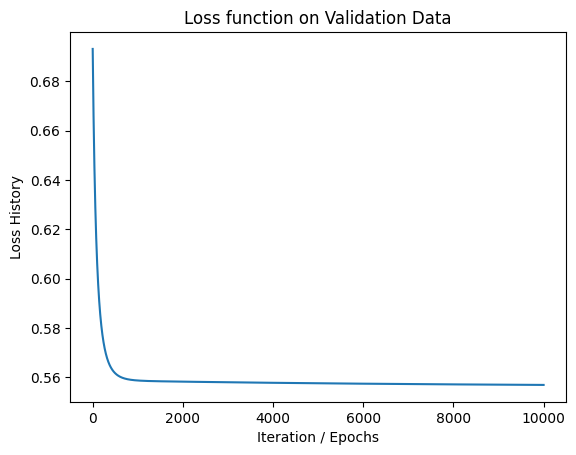

In [11]:
lr = LogisticRegression_custom()
lr.fit(x_train, y_train)
validation_predictions = lr.predict(x_validate)
acc, f1_score, cm = lr.evaluate(y_validate, validation_predictions)
print("Logistic Regression from Scratch - Validation Data Results:")
print(" ")
print("Accuracy:", (acc * 100), "%")
print(" ")
print("F1 Score:", f1_score)
print(" ")
print("Confusion Matrix for Evaluation:")
print(cm)

loss_history = lr.loss_history
# plotting the loss history over the total number of iterations
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Iteration / Epochs")
plt.ylabel("Loss History")
plt.title("Loss function on Validation Data")
plt.show()

### Running the model and showing the test data results:

Running the logistic regression model on the test dataset.

Logistic Regression from Scratch - Testing:
 
Accuracy: 73.396 %
 
F1 Score: 0.738180529858678
 
Confusion Matrix for Test Data:
[[ 9376  3527]
 [ 3124 15624]]


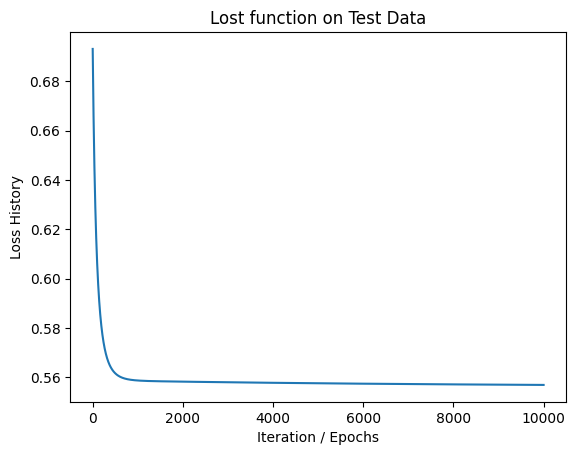

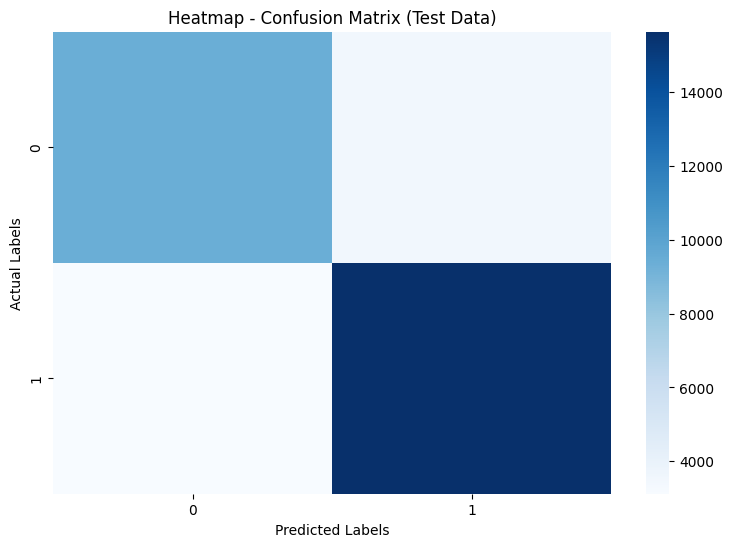

In [13]:
lr = LogisticRegression_custom()
lr.fit(x_train, y_train)
test_predictions = lr.predict(x_test)
acc, f1_score, cm = lr.evaluate(y_test, test_predictions)
print("Logistic Regression from Scratch - Testing:")
print(" ")
print("Accuracy:", (acc * 100), "%")
print(" ")
print("F1 Score:", f1_score)
print(" ")
print("Confusion Matrix for Test Data:")
print(cm)

loss_history = lr.loss_history
# plotting the loss history over the total number of iterations
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Iteration / Epochs")
plt.ylabel("Loss History")
plt.title("Lost function on Test Data")
plt.show()

# creating a heatmap for the confusion matrix
plt.figure(figsize = (9, 6))
sns.heatmap(cm, annot = False, cmap = 'Blues', cbar = True)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Heatmap - Confusion Matrix (Test Data)")
plt.show()

Finish.